# **Notebook 3: Machine Learning Model**

## Objectives

* Create ML model for predicting future CO2 levels based on current data

## Inputs

* clean_data.csv produced by Notebook 1

## Outputs

* Generates a predictive ML model for use with climate data 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

# Import Packages and Data

Import packages needed to run this notebook

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

# Cluster evaluation
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

Import cleaned dataset

In [ ]:
#set path to clean data file
path = "../raw_data/clean_data.csv"

# read data into dataframe
df_clean = pd.read_csv(path, parse_dates=['year'])

# display data types for verification
df_clean.info()


# Using Linear Regression to Predict Global CO2 levels over time

### Create train and test data sets
First I created a dataset with the columns of interest, with values summed by year.<br>
From the visualisations I know that per capita CO2 is falling over time, but it would be good to visualise total CO2 levels as this is what the model will be predicting.<br>
(Steps modified from https://www.geeksforgeeks.org/machine-learning/step-by-step-guide-to-modeling-time-series-data-using-linear-regression/)

In [ ]:
# create dataset with year and co2 columns only, co2 is summed across all countries
df_global = df_clean[['year', 'co2']].groupby('year', as_index=False).sum()

sns.scatterplot(df_global, x='year', y='co2')
plt.title("Global CO2 Emissions Over Time")
plt.xlabel("Year")
plt.ylabel("Total CO2")
#plt.xticks({df_global['year'] : df_global['year'].dt.year})
plt.show()

This graph shows that global CO2 levels are increasing over time.

Next I split our data into a train and test set, this lets me hold back some unseen data to test the model on after training.<br>

In [ ]:
# convert year (datetime) to numeric ordinal for regression
df_global['year'] = df_global['year'].map(pd.Timestamp.toordinal)

# prepare features and target
X = df_global[['year']]
y = df_global['co2']

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.2, random_state=42, shuffle=False
)

print(
	"* Train set:",
	X_train.shape,
	y_train.shape,
	"\n* Test set:",
	X_test.shape,
	y_test.shape,
)

### Model Training and Predictions
Then I can train the model on the training datasets.

In [ ]:
# Initialise linear regression model
model = LinearRegression()

# Traing the model on the training sets
model.fit(X_train, y_train)

I will now make predictions for unseen data based on the trained model.

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)

### Model Evaluation
The final step is to evaluate the model to see how well it predicts unseen data.

In [ ]:
# show Mean Squared Error to evaluate model fit
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse.round(2)}')

This error value seems quite high, suggesting that out model is not predicting CO2 very accurately.<br>
Now I will plot actual versus predicted values to visualise the performance of the model.

In [ ]:
# Plotting the actual vs predicted values inorder to visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(df_global.index, df_global['co2'], label='Actual')
plt.plot(X_test.index, y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted CO2 Emission Levels')
plt.xlabel('Year')
plt.ylabel('Global CO2 Levels')
plt.legend()
plt.show()

This chart shows that the model is not a good predictor for CO" levels over time and is likely to underestimate future values.<br>
This suggests that CO2 emissions are more complex than a simple regression model can manage.

# Clustering Countries
This model aims to categories countries into clusters based on emissions profiles. This will allow targeted interventions for emission reductions based on which cluster a country belongs to.

### Define the Dataset
I want to train this model on the most recent data for each country, so I will create a dataframe with only records from 2023.

In [ ]:
# create a dataframe with rows where year is 2023 and keep only numeric columns, missing values will be dropped
df_2023 = df_clean[df_clean['year'].dt.year == 2023].select_dtypes(include=[np.number]).dropna().copy()
df_2023.head()

,primary_energy_consumption,co2,co2_including_luc,total_ghg,co2_growth_abs,co2_growth_prct,co2_per_capita,co2_per_gdp,energy_per_capita,energy_per_gdp,...,gas_co2,land_use_change_co2,oil_co2,share_global_co2,share_global_co2_including_luc,cumulative_co2,cumulative_co2_including_luc,share_global_cumulative_co2,pop(m),gdp($b)
48,705.003,178.133,180.335,282.645,-6.425,-3.481,3.859,2.989712e-10,15458.390,1.183248e-09,...,92.546,2.202,59.966,0.471,0.435,5263.690,6187.045,0.290,46.16,595.82
97,1019.741,195.806,306.446,422.011,-8.275,-4.055,4.300,2.290359e-10,22277.793,1.192800e-09,...,91.051,110.640,93.742,0.518,0.740,9012.649,22777.850,0.497,45.54,854.91
146,1672.456,382.972,453.066,580.988,-1.390,-0.362,14.478,2.848964e-10,63256.879,1.244155e-09,...,74.636,70.094,141.596,1.013,1.094,19664.301,33841.180,1.085,26.45,1344.25
195,384.811,58.578,56.930,67.949,-2.911,-4.734,6.416,1.468801e-10,42952.613,9.648860e-10,...,13.832,-1.648,30.733,0.155,0.137,5693.515,5870.665,0.314,9.13,398.82
244,508.489,113.427,131.913,263.614,-0.436,-0.383,0.662,1.321771e-10,2940.021,5.925451e-10,...,56.181,18.486,31.796,0.300,0.319,1922.090,3505.443,0.106,171.47,858.14


### Create Cluster Pipeline
First I create a pipeline to perform feature scaling, principal component analysis (PCA) and define the model steps.

In [12]:
# Create pipeline for ML clustering model
def PipelineCluster():
  pipeline_base = Pipeline([
      # feature scaling
      ("scaler", StandardScaler()),    
      # pca
      ("PCA",  PCA(n_components=50, random_state=0)), 
      # modelling
      ("model", KMeans(n_clusters=50, random_state=0)), 
  ])
  return pipeline_base

PipelineCluster()

Pipeline(steps=[('scaler', StandardScaler()),
                ('PCA', PCA(n_components=50, random_state=0)),
                ('model', KMeans(n_clusters=50, random_state=0))])

### Determine suitable n_component value for PCA
This step helps to work out how many components to evaluate in the PCA step. <br>
First I will clean and scale the data to prepare it for PCA.

In [ ]:
# create a pipeline with just the feature scaling step to prepare data for PCA
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df_2023)

print(df_pca.shape,'\n', type(df_pca))

(56, 23) 
 <class 'numpy.ndarray'>


Now I will apply PCA to the scaled data to see how much variance is explained by each component.

In [ ]:
n_components = 23 # set the number of components to match number of columns in the data

pca = PCA(n_components=n_components).fit(df_pca)  # set PCA object and fit to the data
x_PCA = pca.transform(df_pca) # array with transformed PCA

# store variance information to dataframe for evaluation
ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,3),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

# prints how much of the dataset these components explain which is useful for comparing different component values
PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
print(dfExplVarRatio)

* The 23 components explain 100.0% of the data 

              Explained Variance Ratio (%)
Component 0                         57.887
Component 1                         13.680
Component 2                         11.413
Component 3                          6.369
Component 4                          4.297
Component 5                          2.774
Component 6                          1.427
Component 7                          0.973
Component 8                          0.629
Component 9                          0.225
Component 10                         0.156
Component 11                         0.074
Component 12                         0.045
Component 13                         0.029
Component 14                         0.009
Component 15                         0.007
Component 16                         0.003
Component 17                         0.001
Component 18                         0.000
Component 19                         0.000
Component 20                         0.000
Compo

This shows that most of the variance can be explained by the first few components.<br>
I will run the PCA again using only 5 components to see how well that covers the data.

In [ ]:
n_components = 5

pca = PCA(n_components=n_components).fit(df_pca)  # set PCA object and fit to the data
x_PCA = pca.transform(df_pca) # array with transformed PCA

# store variance information to dataframe for evaluation
ComponentsList = ["Component " + str(number) for number in range(n_components)]
dfExplVarRatio = pd.DataFrame(
    data= np.round(100 * pca.explained_variance_ratio_ ,3),
    index=ComponentsList,
    columns=['Explained Variance Ratio (%)'])

# prints how much of the dataset these components explain which is useful for comparing different component values
PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum()

print(f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
print(dfExplVarRatio)

* The 5 components explain 93.65% of the data 

             Explained Variance Ratio (%)
Component 0                        57.887
Component 1                        13.680
Component 2                        11.413
Component 3                         6.369
Component 4                         4.297


These five components cover over 90% of that data, so should give a good balance between coverage and performance for the model.<br>
I will now define the pipeline again, with the updated n_components value

In [18]:
# Create pipeline for ML clustering model
def PipelineCluster():
  pipeline_base = Pipeline([
      # feature scaling
      ("scaler", StandardScaler()),    
      # pca
      ("PCA",  PCA(n_components=5, random_state=0)), 
      # modelling
      ("model", KMeans(n_clusters=50, random_state=0)), 
  ])
  return pipeline_base

PipelineCluster()

Pipeline(steps=[('scaler', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=0)),
                ('model', KMeans(n_clusters=50, random_state=0))])

### Determine suitable number of clusters
Next I will use the elbow method and silhouette score to work out the most suitable number of clusters for the model.<br>
The first step is to prepare the data for analysis by creating a pipeline with feature scaling and PCA steps.

In [19]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_2023)

print(df_analysis.shape,'\n', type(df_analysis))

(56, 5) 
 <class 'numpy.ndarray'>


Next I will create plots to evaluate clusters using the elbow method.

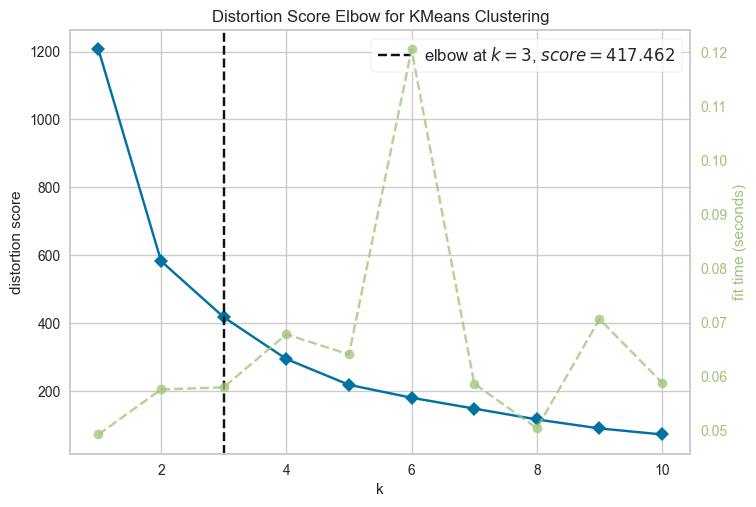

In [24]:
# define visualiser for kmeans algorithm and number of clusters to test
visualiser = KElbowVisualizer(KMeans(n_init=10, random_state=0), k=(1,11))
visualiser.fit(df_analysis) 
visualiser.show() 
plt.show()

This sugggests that 3 clusters would be best.<br>
There is also a steep increase in fit time at 6 clusters, so for efficiency it would be best to stay below this number.

I will also test silhouette scores to see if this agrees with the elbow method.

=== Silhouette plot for 2 Clusters ===


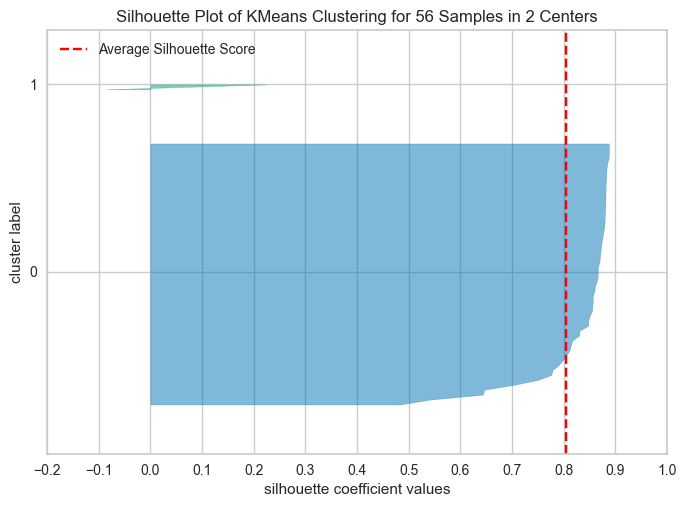



=== Silhouette plot for 3 Clusters ===


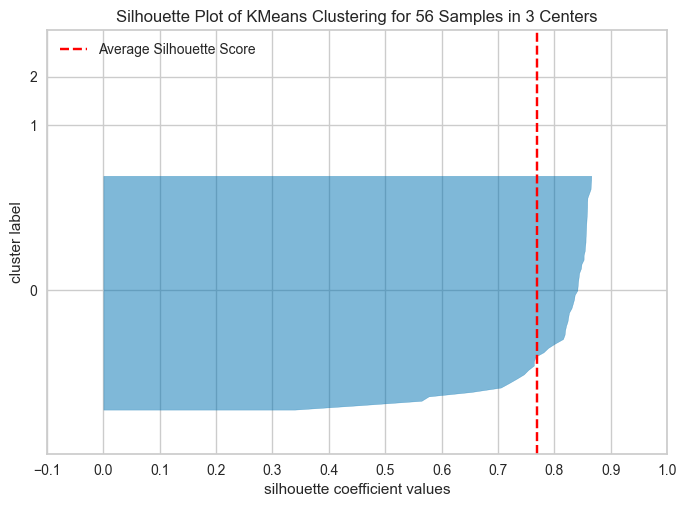



=== Silhouette plot for 4 Clusters ===


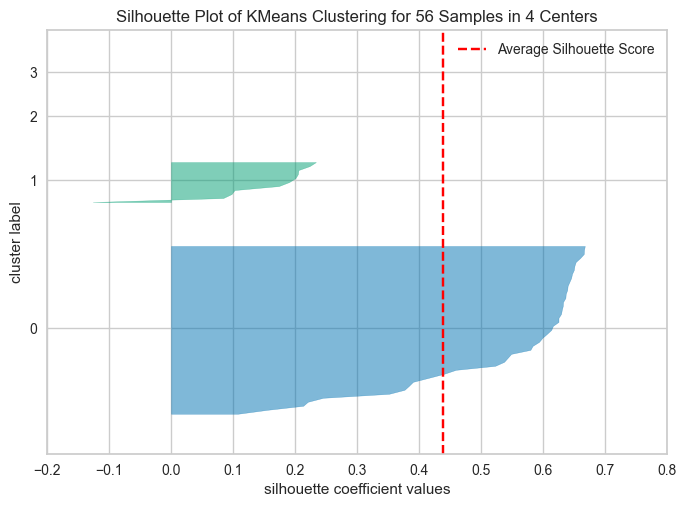



=== Silhouette plot for 5 Clusters ===


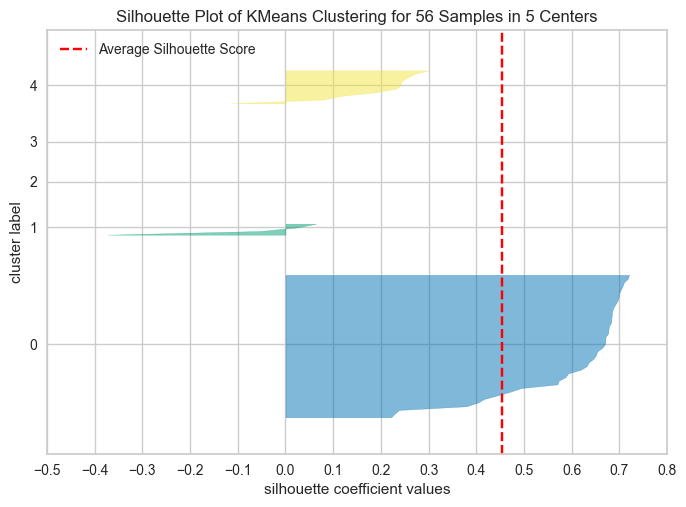

In [27]:
# create silhouette plots to check 2-5 clusters
for n_clusters in np.arange(start=2,stop=6):
  
  print(f"=== Silhouette plot for {n_clusters} Clusters ===")
  visualizer = SilhouetteVisualizer(estimator = KMeans(n_clusters=n_clusters, random_state=0, n_init=10),
                                    colors = 'sns_colorblind')
  visualizer.fit(df_analysis)
  visualizer.show()
  plt.show()
  print("\n")

In [42]:
# Create pipeline for ML clustering model
def PipelineCluster():
  pipeline_base = Pipeline([
      # feature scaling
      ("scaler", StandardScaler()),    
      # pca
      ("PCA",  PCA(n_components=5, random_state=0)), 
      # modelling
      ("model", KMeans(n_clusters=3, random_state=0)), 
  ])
  return pipeline_base

PipelineCluster()

Pipeline(steps=[('scaler', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=0)),
                ('model', KMeans(n_clusters=3, random_state=0))])

### Fit cluster pipeline

In [43]:
# create a copy of the data for training
X = df_2023.copy()
# fit the cluster pipeline to the training data
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

# add a column to our training data for cluster predictions
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(56, 24)


c:\Users\Emily\Documents\code-institute-projects\co2-emissions\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,primary_energy_consumption,co2,co2_including_luc,total_ghg,co2_growth_abs,co2_growth_prct,co2_per_capita,co2_per_gdp,energy_per_capita,energy_per_gdp,...,land_use_change_co2,oil_co2,share_global_co2,share_global_co2_including_luc,cumulative_co2,cumulative_co2_including_luc,share_global_cumulative_co2,pop(m),gdp($b),Clusters
48,705.003,178.133,180.335,282.645,-6.425,-3.481,3.859,2.989712e-10,15458.390,1.183248e-09,...,2.202,59.966,0.471,0.435,5263.690,6187.045,0.290,46.16,595.82,0
97,1019.741,195.806,306.446,422.011,-8.275,-4.055,4.300,2.290359e-10,22277.793,1.192800e-09,...,110.640,93.742,0.518,0.740,9012.649,22777.850,0.497,45.54,854.91,0
146,1672.456,382.972,453.066,580.988,-1.390,-0.362,14.478,2.848964e-10,63256.879,1.244155e-09,...,70.094,141.596,1.013,1.094,19664.301,33841.180,1.085,26.45,1344.25,0


Visualise cluster frequencies

* Clusters frequencies 
          proportion
Clusters            
0               0.96
1               0.02
2               0.02 




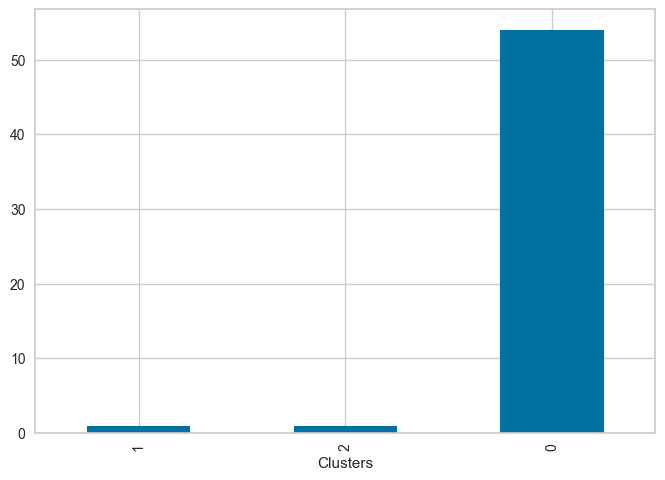

In [44]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

### Find the profile for each cluster

In [45]:
# create a copy of the cluster dataset
df_clf = X.copy()

#split data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(
                                    df_clf.drop(['Clusters'],axis=1),
                                    df_clf['Clusters'],
                                    test_size=0.2,
                                    random_state=0
                                    )

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(44, 23) (44,) (12, 23) (12,)


Create a pipeline to classify clusters

In [46]:
# create pipeline to classify clusters by features
def PipelineClf2ExplainClusters():
  pipeline_base = Pipeline([

      ("scaler", StandardScaler()  ),    

      ("feat_selection", SelectFromModel(GradientBoostingClassifier(random_state=0)) ), 

      ("model",  GradientBoostingClassifier(random_state=0) ), 
  ])
  return pipeline_base

  
PipelineClf2ExplainClusters()

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

Fit the model to the training data

In [47]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

### Evaluate model performance
First I will look at performance on the training set

In [48]:
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           2       1.00      1.00      1.00         1

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



and then compare this to performance on the test set.

In [49]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       0.00      0.00      0.00         1

    accuracy                           0.92        12
   macro avg       0.46      0.50      0.48        12
weighted avg       0.84      0.92      0.88        12



c:\Users\Emily\Documents\code-institute-projects\co2-emissions\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Emily\Documents\code-institute-projects\co2-emissions\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Emily\Documents\code-institute-projects\co2-emissions\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.